# Setting variables

In [47]:
import os
%load_ext rpy2.ipython
#%load_ext pushnote

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [48]:
%%R
workDir = '/home/chantal/Chazy/Chazy_SIP/data'
figDir = '/home/chantal/Chazy/Chazy_SIP/data/figs'

# log2 fold change
l2fcResDir = '/home/chantal/Chazy/Chazy_SIP/data/'
l2fcResFile = file.path(l2fcResDir, 'l2fc_sparse-maxRejH.txt')

# physeq file
physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqBulk = 'bulkSIP-core' 

# params
padj.cutoff = 0.1   # adjusted p-value cutoff for selecting incorporators
nprocs = 14

# Init

In [49]:
%Rpull workDir
workDir = workDir[0]
if not os.path.isdir(workDir):
    os.makedirs(workDir)
    
%cd $workDir    

/home/chantal/Chazy/Chazy_SIP/data


In [50]:
%%R
library(dplyr)
library(tidyr)
library(ggplot2)
library(phyloseq)
library(dynamicTreeCut)
library(ComplexHeatmap)

# Loading files

In [51]:
%%R 
# log2 fold change analysis results file
df.l2fc = read.delim(l2fcResFile, sep='\t') %>%
    mutate(Rank2 = gsub('^__', '', Rank2),
           Rank3 = gsub('^__', '', Rank3),
           Rank4 = gsub('^__', '', Rank4),
           Rank5 = gsub('^__', '', Rank5),
           Rank6 = gsub('^__', '', Rank6),
           Rank7 = gsub('^__', '', Rank7))
df.l2fc %>% head(n=3)

  Treatment Day Replicate Land_Management      OTU log2FoldChange         p
1       13C   3         4             NTH OTU.4163      0.2905525 0.4758928
2       13C   3         4             NTH OTU.5493     -0.2477539 0.8663980
3       13C   3         4             NTH OTU.1739     -0.3623365 0.9103254
  padj    Rank1          Rank2 Rank3                Rank4 Rank5 Rank6 Rank7
1    1 Bacteria    Chloroflexi  S085 uncultured_bacterium  <NA>  <NA>  <NA>
2    1 Bacteria    Chloroflexi  S085 uncultured_bacterium  <NA>  <NA>  <NA>
3    1 Bacteria Planctomycetes OM190 uncultured_bacterium  <NA>  <NA>  <NA>
  Rank8 density_min density_max sparsity_threshold
1  <NA>         1.7        1.73               0.05
2  <NA>         1.7        1.73               0.05
3  <NA>         1.7        1.73               0.05


## prefractionation abundances

In [52]:
%%R 
F = file.path(physeqDir, physeqBulk)
physeq.bulk = readRDS(F)
physeq.bulk.m = physeq.bulk %>% sample_data



physeq.bulk.m = physeq.bulk %>% sample_data

physeq.bulk = physeq.bulk %>% transform_sample_counts(function(x) x/sum(x))

physeq.bulk.m = physeq.bulk %>% sample_data

physeq.bulk = prune_samples(physeq.bulk.m$Treatment %in% c('12C') & physeq.bulk.m$Replicate == 4, physeq.bulk) %>% 
    filter_taxa(function(x) sum(x) > 0, TRUE)
physeq.bulk.m = physeq.bulk %>% sample_data
        

        
print(physeq.bulk)


df.bulk = physeq.bulk %>% otu_table %>% as.data.frame
df.bulk$OTU = rownames(df.bulk)
df.bulk$OTU = NULL
colnames(df.bulk) = gsub('(Day[0-9]+).+', '\\1', colnames(df.bulk))
df.bulk %>% head(n=3) 

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 7820 taxa and 10 samples ]
sample_data() Sample Data:       [ 10 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 7820 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 7820 tips and 7819 internal nodes ]
         12C.NTH.Day14 12C.PTH.Day7 12C.NTH.Day1 12C.NTH.Day3 12C.NTH.Day30
OTU.4940  0.000000e+00            0 0.0000000000            0  0.0000000000
OTU.1739  9.663703e-05            0 0.0000000000            0  0.0000000000
OTU.1813  0.000000e+00            0 0.0001206273            0  0.0001795816
         12C.PTH.Day30 12C.PTH.Day1 12C.PTH.Day3 12C.NTH.Day7 12C.PTH.Day14
OTU.4940  0.000000e+00            0 0.000000e+00 7.679902e-05  0.000000e+00
OTU.1739  7.242703e-05            0 8.047966e-05 0.000000e+00  8.350731e-05
OTU.1813  0.000000e+00            0 0.000000e+00 7.679902e-05  8.350731e-05


# Selecting incorporators

In [53]:
%%R

df.inc = df.l2fc %>%
    filter(padj < padj.cutoff, Treatment == '13X')

cat('Total number of incorporator OTUs:', df.inc$OTU %>% unique %>% length, '\n')

Total number of incorporator OTUs: 834 


In [54]:
%%R
df.l2fc = df.l2fc %>% filter(Treatment == '13X') %>%
    mutate(Incorporator = (padj < padj.cutoff) %>% as.numeric) 
df.l2fc %>% head(n=3)

  Treatment Day Replicate Land_Management      OTU log2FoldChange         p
1       13X   3         4             PTH OTU.1813     0.18725056 0.5192869
2       13X   3         4             PTH OTU.2180    -0.08299578 0.6044085
3       13X   3         4             PTH OTU.2343    -0.51535570 0.7149663
  padj    Rank1          Rank2        Rank3                Rank4 Rank5 Rank6
1    1 Bacteria Planctomycetes        OM190 uncultured_bacterium  <NA>  <NA>
2    1 Bacteria Planctomycetes Pla4_lineage uncultured_bacterium  <NA>  <NA>
3    1 Bacteria Planctomycetes Pla4_lineage uncultured_bacterium  <NA>  <NA>
  Rank7 Rank8 density_min density_max sparsity_threshold Incorporator
1  <NA>  <NA>        1.72        1.75               0.15            0
2  <NA>  <NA>        1.72        1.75               0.15            0
3  <NA>  <NA>        1.72        1.75               0.15            0


## l2fc matrix

In [55]:
%%R 
# selecting all incorporator OTUs, keeping l2fc values for all substrates/days

cat('Total number of incorporator OTUs:', df.inc$OTU %>% unique %>% length, '\n')

df.l2fc.w = df.l2fc %>%
    filter(OTU %in% df.inc$OTU & Treatment == '13X') %>%
    mutate(Day = gsub('^', 'D', Day)) %>%
    unite(Substrate_Day_LM, Treatment, Land_Management, Day, sep='_') %>%
    dplyr::select(OTU, Substrate_Day_LM, log2FoldChange, Rank2) %>%
    spread(Substrate_Day_LM, log2FoldChange, fill=0) 

#df.l2fc.w = arrange(df.l2fc.w, Rank2)

rownames(df.l2fc.w) = df.l2fc.w$OTU
df.l2fc.w$Rank2 = NULL
df.l2fc.w$OTU = NULL
colnames(df.l2fc.w) = gsub('13C-', '', colnames(df.l2fc.w))
colnames(df.l2fc.w) = gsub('D([0-9])$', 'D0\\1', colnames(df.l2fc.w))

df.l2fc.w %>% nrow %>% print
df.l2fc.w %>% head(n=3)

Total number of incorporator OTUs: 834 
[1] 834
        13X_NTH_D01 13X_NTH_D14 13X_NTH_D03 13X_NTH_D07 13X_PTH_D01 13X_PTH_D14
OTU.1     1.5463473   2.8739045  1.54068763  2.79405112    1.318058    1.852219
OTU.10    2.2023602   5.2451284  2.61370695  1.48897718    3.200209    4.492707
OTU.100   0.2481337   0.6840545 -0.04228209  0.05995108    1.586107    1.419896
        13X_PTH_D03 13X_PTH_D07
OTU.1     0.3099758    1.323305
OTU.10    2.9398630    2.761244
OTU.100   1.1269711   -1.341951


# ComplexHeatmap

### column order

In [114]:
%%R
col.order = c(
"13X_NTH_D01",
"13X_NTH_D03",
"13X_NTH_D07",
"13X_NTH_D14",
"13X_PTH_D01",
"13X_PTH_D03",
"13X_PTH_D07",
"13X_PTH_D14")

col.bySub = list(N_13X=1:4, P_13X=5:8)

### Row order

In [115]:
%%R
dist.fun = function(x) as.dist((1-cor(t(x)))/2)
row.hc = df.l2fc.w %>% dist.fun %>% hclust(method='average')
row.phy = ape::as.phylo(row.hc) 
row.phy = ape::ladderize(row.phy)
row.dend = as.dendrogram(row.phy)

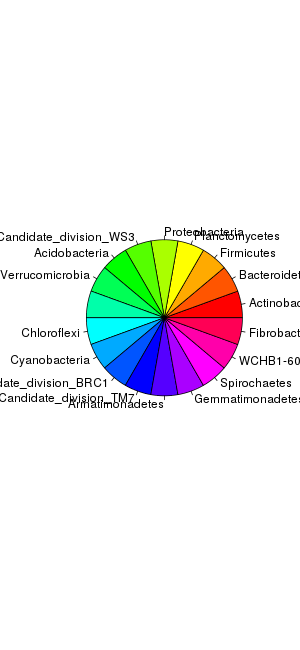

In [116]:
%%R -w 300 -h 650
# splitting phyla into 2 columns
df.l2fc.phy = df.l2fc %>% filter(Treatment == '13X', Day %in% c(1,3)) %>%
    dplyr::select(OTU, Rank2) %>%
    distinct(OTU, Rank2) 
rownames(df.l2fc.phy) = df.l2fc.phy$OTU

df.l2fc.phy = df.l2fc.phy[rownames(df.l2fc.w),]
df.l2fc.phy = df.l2fc.phy %>%
    dplyr::select(Rank2) %>%
    mutate(Rank2 = Rank2 %>% as.character)


# splitting into 2 columns
#n.rank = df.l2fc.phy$Rank2 %>% unique %>% length
#df.l2fc.phy = df.l2fc.phy %>%
   # mutate(Rank2.n = Rank2 %>% as.factor %>% as.numeric,
    #       group = ifelse(Rank2.n < n.rank / 2, 1, 2),
     #      Phylum.A = ifelse(group==1, Rank2, 'Phylum.B'),
      #     Phylum.B = ifelse(group==2, Rank2, 'Phylum.A')) %>%
    #select(Phylum.A, Phylum.B)


# coloring
## groupA

tax = df.l2fc.phy$Rank2 %>% unique

#tax = df.l2fc.phy$Phylum.A %>% unique
#tax = tax[tax != 'Phylum.B'] %>% as.vector
n.tax = tax %>% length
colors = rainbow(n.tax)
tax.cols.a = setNames(colors, tax)
#tax.cols.a = append(tax.cols.a, c('Phylum.B' = '#CCCCCC'))
## groupB
#tax = df.l2fc.phy$Phylum.B %>% unique
#tax = tax[tax != 'Phylum.A']
#n.tax = tax %>% length
#colors = rainbow(n.tax)
#tax.cols.b = setNames(colors, tax)
#tax.cols.b = append(tax.cols.b, c('Phylum.A' = '#CCCCCC'))

# rownames
rownames(df.l2fc.phy) = rownames(df.l2fc.w)

# plotting
HM.tax = HeatmapAnnotation(df = df.l2fc.phy, 
                           col = list(Phylum = tax.cols.a),#,
                                    #  Phylum.B = tax.cols.b),
                           na_col = '#000000',
                           which='row', 
                           width=unit(8, 'mm'),
                           gap=unit(0.5,'mm'))


pie(rep(1, n.tax), labels=tax, col=colors)

## preFrac rel-abund heatmap

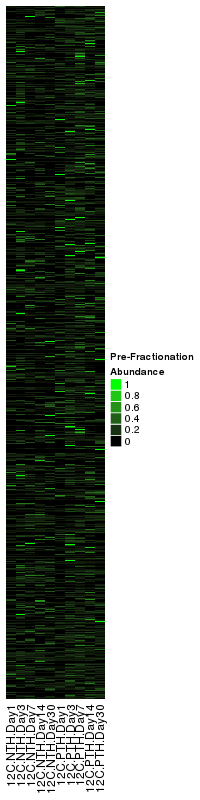

In [117]:
%%R -h 800 -w 200
# adding taxa found in fractions but not in bulk-abundances
not.in = setdiff(rownames(df.l2fc.w), rownames(df.bulk))
df.not.in = matrix(nrow=length(not.in), ncol=ncol(df.bulk)) %>% as.data.frame
colnames(df.not.in) = colnames(df.bulk)
rownames(df.not.in) = not.in
df.not.in[is.na(df.not.in)] = 0

# filtering and ordering
df.bulk.f = rbind(df.bulk, df.not.in)
df.bulk.f = df.bulk.f[rownames(df.l2fc.w),] 

# transforming
df.bulk.f = apply(df.bulk.f, 1, function(x) x / sum(x)) %>% t
df.bulk.f[is.nan(df.bulk.f)] = 0

# column order
#colnames(df.bulk.f) = gsub('D([0-9])$', 'D0\\1', df.bulk.f %>% colnames)
pf.col.order = c('12C.NTH.Day1', '12C.NTH.Day3', '12C.NTH.Day7', '12C.NTH.Day14', '12C.NTH.Day30',
                 '12C.PTH.Day1', '12C.PTH.Day3', '12C.PTH.Day7', '12C.PTH.Day14', '12C.PTH.Day30')
                 #'D03', 'D06', 'D14', 'D30', 'D48')
    
# making heatmap
min.abnd = df.bulk.f %>% as.matrix %>% as.vector %>% min
max.abnd = df.bulk.f %>% as.matrix %>% as.vector %>% max
HM.pf = Heatmap(df.bulk.f %>% as.matrix, 
        name='Pre-Fractionation\nAbundance', 
        col = circlize::colorRamp2(c(min.abnd, max.abnd), 
                                   c("black", "green")),
        show_row_names=FALSE,
        combined_name_fun=NULL,
        cluster_columns=FALSE,
        cluster_rows=FALSE,
        column_order=pf.col.order,
        gap = unit(0.4, "mm"))
HM.pf

### Heatmap

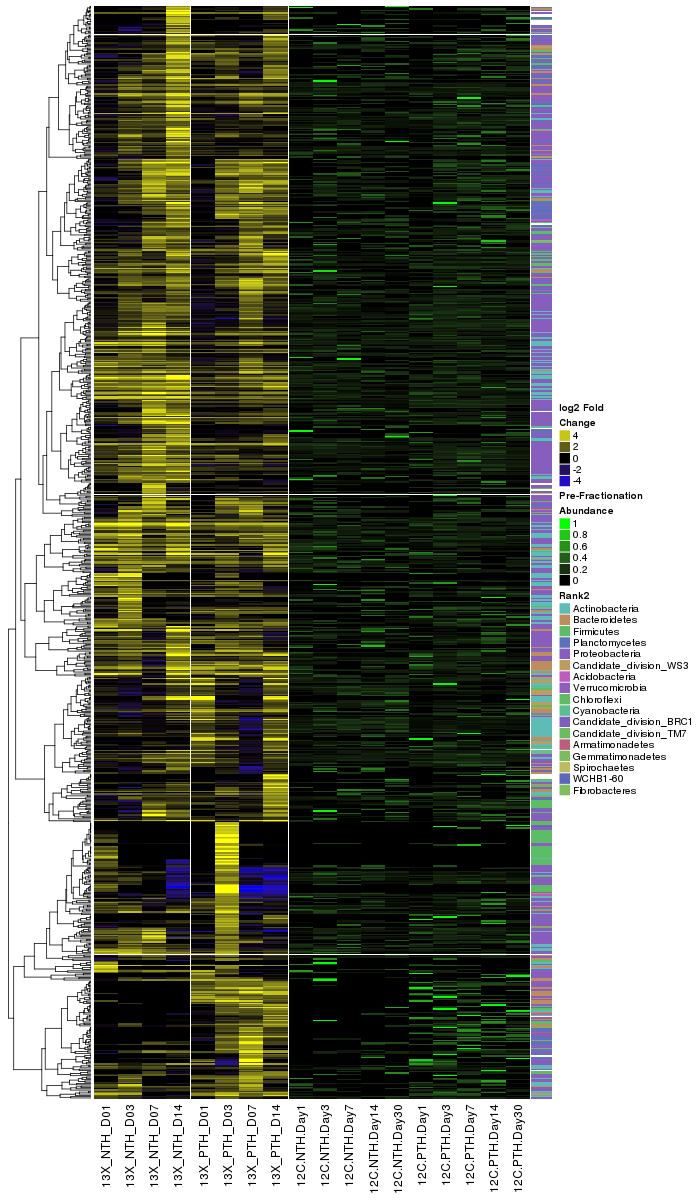

In [118]:
%%R -h 1200 -w 700
Heatmap_bySubstrate = function(idx, df, dend, col.order, col, hc){
    
    if(idx[1] == 1){
        show_row_dend = TRUE
        show_heatmap_legend = TRUE
    } else{
        show_row_dend = FALSE
        show_heatmap_legend = FALSE
    }
    
    H = Heatmap(df[,idx], 
        cluster_columns = FALSE,
        cluster_rows = dend,        
        column_order=col.order[idx],
        show_row_names=FALSE,
        show_heatmap_legend = show_heatmap_legend,
        row_dend_width = unit(30, "mm"),
        name = "log2 Fold\nChange",
        col=col,
        gap = unit(0.4, "mm"))
    return(H)
    }


# heatmap gradient color scheme
col = circlize::colorRamp2(c(-5, 0, 5), c("blue", "black", "yellow"))

# making separate heatmaps for each substrate
HMs = lapply(col.bySub, Heatmap_bySubstrate, df=df.l2fc.w[,col.order], 
             col.order=col.order, col=col, dend=row.dend)

HMs = HMs[[1]] + HMs[[2]] + HM.pf + HM.tax

# plotting
draw(HMs, gap=unit(0.4, 'mm'))

# DynamicTreeCut

* defining clusters with dynamicTreeCut method

In [119]:
%%R
dist.fun = function(x) as.dist((1-cor(t(x)))/2)
row.dist =  df.l2fc.w %>% dist.fun    
row.hc = row.dist %>% hclust(method='average')

In [192]:
%%R
cth.res = cutreeHybrid(row.hc, row.dist %>% as.matrix, deepSplit=0, minClusterSize = 20)
df_splits = data.frame(OTU = rownames(df.l2fc.w),
                       splits = cth.res$labels)

 ..cutHeight not given, setting it to 0.551  ===>  99% of the (truncated) height range in dendro.
 ..done.


In [193]:
%%R
head(df.l2fc.w)

          13X_NTH_D01 13X_NTH_D14 13X_NTH_D03 13X_NTH_D07 13X_PTH_D01
OTU.1       1.5463473   2.8739045  1.54068763  2.79405112  1.31805823
OTU.10      2.2023602   5.2451284  2.61370695  1.48897718  3.20020865
OTU.100     0.2481337   0.6840545 -0.04228209  0.05995108  1.58610665
OTU.10048   2.2109761   0.0000000  0.00000000  0.00000000  0.00000000
OTU.1005   -0.8601863   3.5316858  2.65792519  2.00761442 -0.69199454
OTU.10051   1.1346564  -0.4930833  1.33654777 -0.73106583  0.05844294
          13X_PTH_D14 13X_PTH_D03 13X_PTH_D07
OTU.1        1.852219   0.3099758   1.3233050
OTU.10       4.492707   2.9398630   2.7612441
OTU.100      1.419896   1.1269711  -1.3419513
OTU.10048    0.000000   3.0411956   0.0000000
OTU.1005     1.563933   0.6970476   0.5215651
OTU.10051   -1.074580   0.7412377   0.1656427


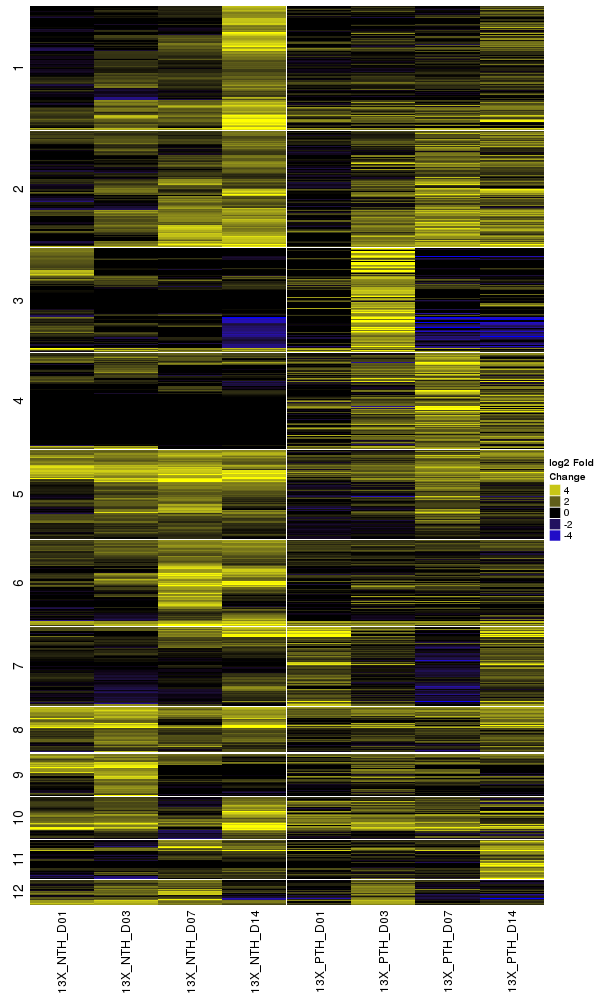

In [350]:
%%R -h 1000 -w 600
Heatmap_bySubstrate = function(idx, df, splits, col.order, col, hc){
    
    if(idx[1] == 1){
       # show_row_dend = TRUE
        
        show_heatmap_legend = TRUE
    } else{
       # show_row_dend = FALSE
        show_heatmap_legend = FALSE
    }
    
    H = Heatmap(df[,idx], 
        cluster_columns = FALSE,
       # cluster_rows = dend,        
        column_order=col.order[idx],
        show_row_names=FALSE,
        show_row_dend=FALSE,
        show_heatmap_legend = show_heatmap_legend,
        row_dend_width = unit(30, "mm"),
        name = "log2 Fold\nChange",
        col=col,
        split=splits,
        gap = unit(0.4, "mm"))
    return(H)
    }


# heatmap gradient color scheme
col = circlize::colorRamp2(c(-5, 0, 5), c("blue", "black", "yellow"))

# making separate heatmaps for each substrate
HMs = lapply(col.bySub, Heatmap_bySubstrate, df=df.l2fc.w[,col.order], 
             col.order=col.order, col=col, splits=df_splits$splits)

HMs = HMs[[1]] + HMs[[2]] 

# histogram; bin rare into other...

# plotting
draw(HMs, gap=unit(0.4, 'mm'))

In [195]:
%%R
df.l2fc.phy$OTU = rownames(df.l2fc.phy)
print(head(df.l2fc.phy))
print(head(df_splits))

                   Rank2       OTU
OTU.1     Actinobacteria     OTU.1
OTU.10     Bacteroidetes    OTU.10
OTU.100   Actinobacteria   OTU.100
OTU.10048     Firmicutes OTU.10048
OTU.1005  Planctomycetes  OTU.1005
OTU.10051 Proteobacteria OTU.10051
        OTU splits
1     OTU.1      6
2    OTU.10     10
3   OTU.100      7
4 OTU.10048      3
5  OTU.1005      1
6 OTU.10051      9


In [280]:
%%R
df.hist = left_join(df_splits, df.l2fc.phy)
head(df.hist)

        OTU splits          Rank2
1     OTU.1      6 Actinobacteria
2    OTU.10     10  Bacteroidetes
3   OTU.100      7 Actinobacteria
4 OTU.10048      3     Firmicutes
5  OTU.1005      1 Planctomycetes
6 OTU.10051      9 Proteobacteria


In [281]:
%%R
df.taxomore = df.l2fc %>% filter(OTU %in% df.inc$OTU & Treatment == '13X') %>% select(OTU, Rank2, Rank3, Rank4,
                                                                                      Rank5, Rank6, Rank7) %>% 
                distinct(OTU)

In [285]:
%%R
df.hist.1b = left_join(df.hist, df.taxmore) %>% distinct(OTU)

In [317]:
%%R
df.hist.1b %>% group_by(splits) %>% distinct(Rank5) %>% summarise(counts = n()) %>% ungroup %>% arrange(splits) 

Source: local data frame [12 x 2]

   splits counts
    (int)  (int)
1       1     30
2       2     30
3       3     34
4       4     37
5       5     26
6       6     27
7       7     18
8       8     19
9       9     28
10     10     21
11     11     16
12     12     13


In [318]:
%%R
df.hist.1b %>% group_by(splits) %>% summarise(counts = n()) %>% ungroup %>% arrange(splits) 

Source: local data frame [12 x 2]

   splits counts
    (int)  (int)
1       1    117
2       2    109
3       3     98
4       4     90
5       5     83
6       6     81
7       7     74
8       8     43
9       9     40
10     10     39
11     11     37
12     12     23


In [293]:
%%R
df.hist.1b %>% group_by(splits) %>% summarise(n = n()) %>% ungroup %>% arrange(n) #%>% summarise(mean(n), sd(n))

Source: local data frame [12 x 2]

   splits     n
    (int) (int)
1      12    23
2      11    37
3      10    39
4       9    40
5       8    43
6       7    74
7       6    81
8       5    83
9       4    90
10      3    98
11      2   109
12      1   117


In [287]:
%%R
df.hist.2 = df.hist.1b %>% group_by(splits, Rank2, Rank3, Rank4, Rank5, Rank6, Rank7) %>% summarise(counts = n())

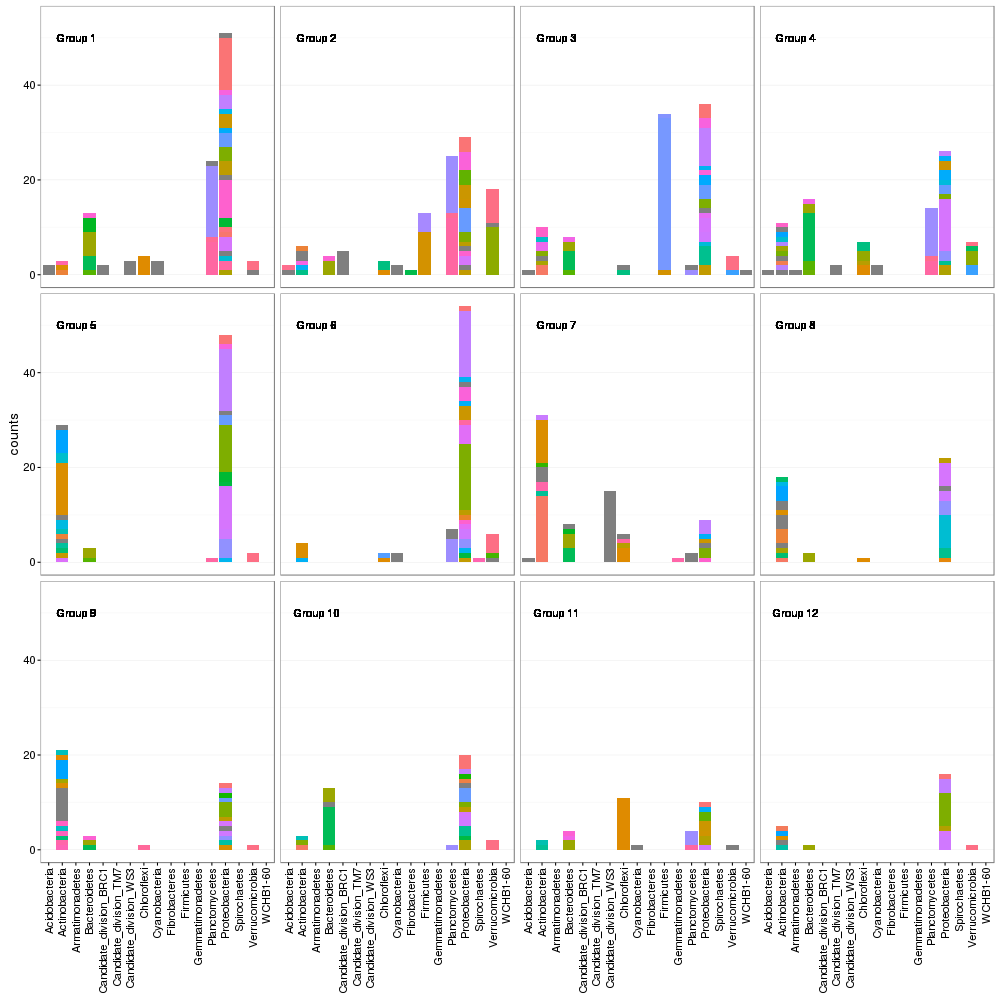

In [357]:
%%R -w 1000 -h 1000
p = ggplot(df.hist.2) + geom_bar(aes(x = Rank2, y = counts, fill = Rank5), stat = 'identity') + facet_wrap(~splits) +
        guides(fill = FALSE) + theme_bw() +  geom_text(x = 3, y = 50, aes(label = paste('Group', splits)), size =4) +
    theme(
        text = element_text(size=14),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5),
        panel.grid.major.x = element_blank(),
        strip.background = element_blank(),
        strip.text = element_blank(),
        legend.position='none'
    ) 
p

In [358]:
%%R
ggsave('figs/xylose_fxnlgrp_tax.jpg', width = 10, height = 10)

In [300]:
%%R
df.hist2 %>% ungroup %>% group_by(splits) %>% mutate(n = sum(counts)) %>% top_n(5, counts) %>% as.data.frame %>% 
            group_by(splits)%>% summarise(percent = sum(counts)/mean(n)) %>% arrange(percent)#%>% 
           # summarise(mean(percent), sd(percent))

Source: local data frame [12 x 2]

   splits   percent
    (int)     (dbl)
1       2 0.8348624
2       1 0.8632479
3      11 0.8918919
4       4 0.9000000
5       7 0.9324324
6       6 0.9382716
7       3 0.9387755
8       5 1.0000000
9       8 1.0000000
10      9 1.0000000
11     10 1.0000000
12     12 1.0000000


In [258]:
%%R
filter(df.hist.2, splits %in% c(5,8,9)) %>% ungroup() %>% group_by(Rank5, Rank4, Rank2) %>% summarise(sum = sum(counts)) %>%
    ungroup() %>% arrange(Rank2, -sum) %>% as.data.frame

                              Rank5                 Rank4           Rank2 sum
1                      Arthrobacter        Micrococcaceae  Actinobacteria  98
2                      Nocardioides       Nocardioidaceae  Actinobacteria  87
3                              <NA>     Microbacteriaceae  Actinobacteria  65
4                         Agromyces     Microbacteriaceae  Actinobacteria  32
5                  Geodermatophilus   Geodermatophilaceae  Actinobacteria  16
6                       Marmoricola       Nocardioidaceae  Actinobacteria  16
7                    Microbacterium     Microbacteriaceae  Actinobacteria  16
8                      Blastococcus   Geodermatophilaceae  Actinobacteria   8
9                      Cellulomonas     Cellulomonadaceae  Actinobacteria   8
10                      Gaiellaceae            Gaiellales  Actinobacteria   8
11                        Georgenia        Bogoriellaceae  Actinobacteria   8
12                       Janibacter    Intrasporangiaceae  Actin

In [264]:
%%R
filter(df.hist.2, splits ==7) %>% ungroup() %>% group_by(Rank5, Rank2) %>% summarise(sum = sum(counts)) %>%
    ungroup() %>% arrange(Rank2, -sum) %>% as.data.frame

                  Rank5                  Rank2 sum
1                  <NA>          Acidobacteria   8
2     Acidimicrobiaceae         Actinobacteria 112
3          Arthrobacter         Actinobacteria  57
4                  <NA>         Actinobacteria  24
5            uncultured         Actinobacteria  16
6             Iamiaceae         Actinobacteria   8
7        Pseudonocardia         Actinobacteria   8
8             Demequina         Actinobacteria   6
9      Chitinophagaceae          Bacteroidetes  20
10    Flavobacteriaceae          Bacteroidetes  15
11                 <NA>          Bacteroidetes   7
12           env.OPS_17          Bacteroidetes   6
13                 <NA> Candidate_division_WS3 118
14      Anaerolineaceae            Chloroflexi  24
15       Caldilineaceae            Chloroflexi   8
16 uncultured_bacterium            Chloroflexi   8
17                 <NA>            Chloroflexi   6
18           uncultured       Gemmatimonadetes   8
19                 <NA>        

In [267]:
%%R
filter(df.hist.2, splits ==3) %>% ungroup()%>% group_by(Rank5, Rank2) %>% summarise(sum = sum(counts)) %>%
    ungroup() %>% arrange(Rank2, -sum) %>% as.data.frame

                   Rank5           Rank2 sum
1                   <NA>   Acidobacteria   8
2           Streptomyces  Actinobacteria  15
3      Acidimicrobiaceae  Actinobacteria  14
4            Clavibacter  Actinobacteria   8
5          Luedemannella  Actinobacteria   6
6                   <NA>  Actinobacteria   6
7                 S24526  Actinobacteria   3
8           Sanguibacter  Actinobacteria   2
9           Cellulomonas  Actinobacteria   1
10     Flavobacteriaceae   Bacteroidetes  29
11      Chitinophagaceae   Bacteroidetes  16
12        Saprospiraceae   Bacteroidetes   8
13         Cytophagaceae   Bacteroidetes   2
14                  <NA>     Chloroflexi   7
15         Herpetosiphon     Chloroflexi   1
16      Paenibacillaceae      Firmicutes  84
17           Bacillaceae      Firmicutes   6
18 Peptostreptococcaceae      Firmicutes   3
19                  <NA>  Planctomycetes   7
20     Planctomycetaceae  Planctomycetes   2
21      Pseudomonadaceae  Proteobacteria  47
22     Hyp

In [305]:
%%R
filter(df.hist.2, splits %in% c(5,6))%>% ungroup()%>% group_by(Rank5, Rank2) %>% summarise(sum = sum(counts)) %>%
    ungroup() %>% arrange(Rank2, -sum) %>% as.data.frame

                   Rank5           Rank2 sum
1           Arthrobacter  Actinobacteria  14
2           Nocardioides  Actinobacteria   5
3                   <NA>  Actinobacteria   3
4            Marmoricola  Actinobacteria   2
5         Microbacterium  Actinobacteria   2
6              Agromyces  Actinobacteria   1
7           Blastococcus  Actinobacteria   1
8       Geodermatophilus  Actinobacteria   1
9             Janibacter  Actinobacteria   1
10             Leifsonia  Actinobacteria   1
11           Nakamurella  Actinobacteria   1
12           Rhodococcus  Actinobacteria   1
13      Chitinophagaceae   Bacteroidetes   2
14         Cytophagaceae   Bacteroidetes   1
15       Anaerolineaceae     Chloroflexi   1
16        Oscillochloris     Chloroflexi   1
17                  <NA>   Cyanobacteria   2
18     Planctomycetaceae  Planctomycetes   5
19                  <NA>  Planctomycetes   2
20  uncultured_bacterium  Planctomycetes   1
21      Pseudomonadaceae  Proteobacteria  27
22        

In [301]:
%%R
filter(df.hist.2, splits %in% c(4))%>% ungroup()%>% group_by(Rank5, Rank2) %>% summarise(sum = sum(counts)) %>%
    ungroup() %>% arrange(Rank2, -sum) %>% as.data.frame

                       Rank5                  Rank2 sum
1                       <NA>          Acidobacteria   1
2                       <NA>         Actinobacteria   3
3                Actinotalea         Actinobacteria   1
4        Cellulosimicrobium_         Actinobacteria   1
5              Cryobacterium         Actinobacteria   1
6                Marmoricola         Actinobacteria   1
7               Nocardioides         Actinobacteria   1
8          Promicromonospora         Actinobacteria   1
9          Pseudokineococcus         Actinobacteria   1
10              Streptomyces         Actinobacteria   1
11                      <NA>        Armatimonadetes   1
12         Flavobacteriaceae          Bacteroidetes  10
13          Chitinophagaceae          Bacteroidetes   2
14             Cytophagaceae          Bacteroidetes   2
15         Cyclobacteriaceae          Bacteroidetes   1
16            Saprospiraceae          Bacteroidetes   1
17                      <NA> Candidate_division_

In [307]:
%%R
filter(df.hist.2, splits %in% c(4))%>% ungroup()%>% group_by(Rank5, Rank2) %>% summarise(sum = sum(counts)) %>%
    ungroup() %>% arrange(-sum) %>% as.data.frame

                       Rank5                  Rank2 sum
1           Rhodobacteraceae         Proteobacteria  11
2          Flavobacteriaceae          Bacteroidetes  10
3          Planctomycetaceae         Planctomycetes  10
4        Chthoniobacteraceae        Verrucomicrobia   3
5       uncultured_bacterium         Planctomycetes   3
6                       <NA>         Actinobacteria   3
7                       <NA>                   <NA>   3
8            Anaerolineaceae            Chloroflexi   2
9         Bacteriovoracaceae         Proteobacteria   2
10          Chitinophagaceae          Bacteroidetes   2
11              Chloroflexus            Chloroflexi   2
12             Cytophagaceae          Bacteroidetes   2
13             Herpetosiphon            Chloroflexi   2
14             Neisseriaceae         Proteobacteria   2
15               Opitutaceae        Verrucomicrobia   2
16          Oxalobacteraceae         Proteobacteria   2
17        Phyllobacteriaceae         Proteobacte

### Smaller version of the heatmap

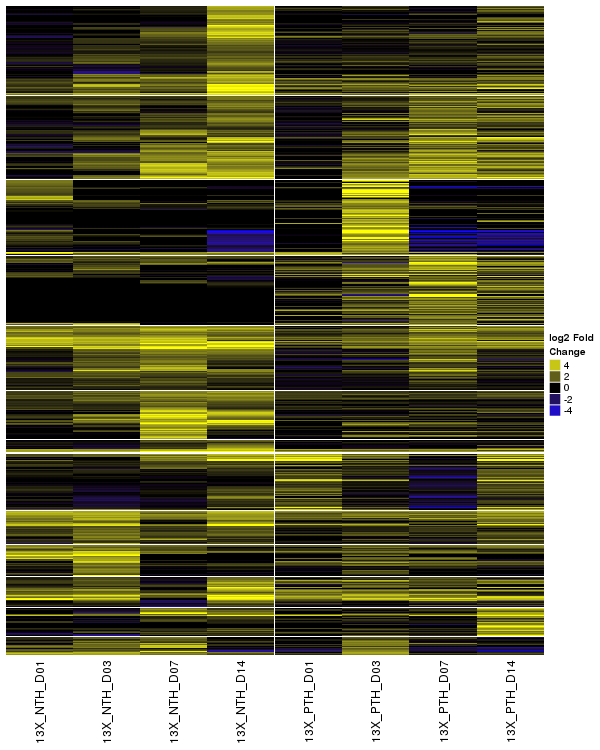

In [347]:
%%R -h 750 -w 600
Heatmap_bySubstrate = function(idx, df, splits, col.order, col, hc){
    
    if(idx[1] == 1){
       # show_row_dend = TRUE
        show_heatmap_legend = TRUE
    } else{
       # show_row_dend = FALSE
        show_heatmap_legend = FALSE
    }
    
    H = Heatmap(df[,idx], 
        cluster_columns = FALSE,
       # cluster_rows = dend,        
        column_order=col.order[idx],
        show_row_names=FALSE,
        show_row_dend=FALSE,
        combined_name_fun=NULL,  # no row titles
       # row_title_gp = gpar(fontsize = 10), 
        show_heatmap_legend = show_heatmap_legend,
        row_dend_width = unit(30, "mm"),
        name = "log2 Fold\nChange",
        col=col,
        split=splits,
        gap = unit(0.4, "mm"))
    return(H)
    }


# heatmap gradient color scheme
col = circlize::colorRamp2(c(-5, 0, 5), c("blue", "black", "yellow"))

# making separate heatmaps for each substrate
HMs = lapply(col.bySub, Heatmap_bySubstrate, df=df.l2fc.w[,col.order], 
             col.order=col.order, col=col, splits=df_splits$splits)

HMs = HMs[[1]] + HMs[[2]]

# plotting
draw(HMs, gap=unit(0.4, 'mm'))

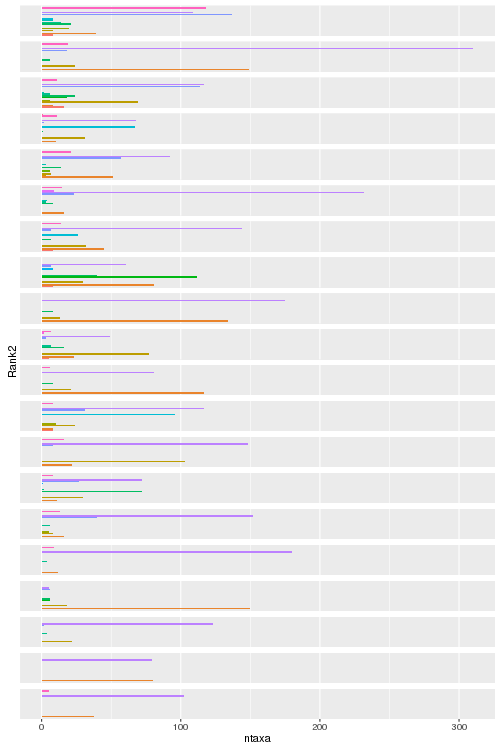

In [128]:
%%R -h 750 -w 500
phyla.hist = df.l2fc.j %>% group_by(func_group, Rank2) %>% summarise(ntaxa = n())

p.test = ggplot(phyla.hist, aes(Rank2, ntaxa, fill = Rank2)) + geom_bar(stat = 'identity', position = 'dodge' ) +
        facet_wrap(~func_group, ncol = 1) + guides(fill = FALSE)  + scale_x_discrete(breaks=NULL)+ guides(fill = FALSE) + 
 theme(strip.background = element_blank(),
       strip.text.x = element_blank(), strip.text.y = element_blank()) + coord_flip() 

p.test

In [351]:
%%R
out.file = file.path(workDir, 'MW-HR-SIP_FG_heatmap.tiff')
tiff(out.file, width=9, height=14, units='in', res=150)
draw(HMs, gap=unit(0.4, 'mm'))
dev.off()
cat('File written: ', out.file, '\n')

File written:  /home/chantal/Chazy/Chazy_SIP/data/MW-HR-SIP_FG_heatmap.tiff 


In [352]:
%%R
out.file = file.path(workDir, 'MW-HR-SIP_FG_heatmap.pdf')
pdf(out.file, width=9, height=10, bg='transparent')
draw(HMs, gap=unit(0.4, 'mm'))
dev.off()
cat('File written: ', out.file, '\n')

File written:  /home/chantal/Chazy/Chazy_SIP/data/MW-HR-SIP_FG_heatmap.pdf 


### Writing out an l2fc table with functional groupings

In [302]:
%%R
df.l2fc.j = inner_join(df.l2fc, df_splits, c('OTU' = 'OTU')) %>%
    rename('func_group' = splits)

df.l2fc.j %>% head(n=3)

  Treatment Day Replicate Land_Management      OTU log2FoldChange            p
1       13X   3         4             PTH OTU.2036       3.239365 4.510373e-06
2       13X   3         4             PTH OTU.5075       1.660147 8.795031e-02
3       13X   3         4             PTH OTU.1272       2.270643 4.763754e-04
          padj    Rank1          Rank2         Rank3             Rank4
1 0.0003307607 Bacteria Planctomycetes Phycisphaerae WD2101_soil_group
2 1.0000000000 Bacteria Planctomycetes Phycisphaerae WD2101_soil_group
3 0.0184403398 Bacteria Planctomycetes Phycisphaerae WD2101_soil_group
                 Rank5 Rank6 Rank7 Rank8 density_min density_max
1 uncultured_bacterium  <NA>  <NA>  <NA>        1.72        1.75
2 uncultured_bacterium  <NA>  <NA>  <NA>        1.72        1.75
3 uncultured_bacterium  <NA>  <NA>  <NA>        1.72        1.75
  sparsity_threshold Incorporator func_group
1               0.15            1          2
2               0.15            0         11
3    

In [303]:
%%R
outFile = file.path(workDir, 'l2fc_sparse-maxRejH_FuncG_xylose.txt')
write.table(df.l2fc.j, outFile, quote=FALSE, sep='\t', row.names=FALSE)
cat('Fill written:', outFile, '\n')

Fill written: /home/chantal/Chazy/Chazy_SIP/data/l2fc_sparse-maxRejH_FuncG_xylose.txt 


In [304]:
%%R
head(df.l2fc.j.s)

Source: local data frame [6 x 7]

  func_group  SubDay_LM Treatment   Day Land_Management  mean_l2fc stderr_l2fc
       (int)     (fctr)    (fctr) (int)          (fctr)      (dbl)       (dbl)
1          1 13X_14_NTH       13X    14             NTH 2.59706648   0.1222245
2          1 13X_14_PTH       13X    14             PTH 1.97078560   0.1301475
3          1  13X_1_NTH       13X     1             NTH 0.03171078   0.1459122
4          1  13X_1_PTH       13X     1             PTH 0.14112462   0.1413146
5          1  13X_3_NTH       13X     3             NTH 0.90714296   0.1405538
6          1  13X_3_PTH       13X     3             PTH 1.75551678   0.1410469


## Plotting functional groups as line plots

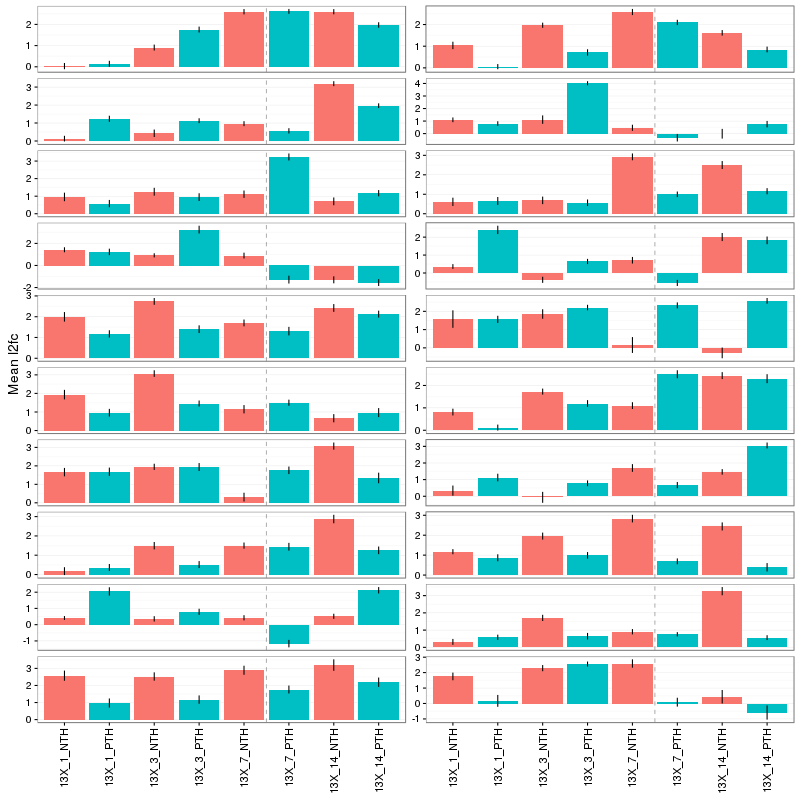

In [134]:
%%R -w 800 -h 800

df.l2fc.j.s = df.l2fc.j %>%
    unite(SubDay_LM, Treatment, Day, Land_Management, sep='_', remove=FALSE) %>%
    group_by(func_group, SubDay_LM, Treatment, Day, Land_Management) %>%
    summarize(mean_l2fc = mean(log2FoldChange),
              stderr_l2fc = sd(log2FoldChange) / sqrt(length(log2FoldChange))) %>%
    ungroup() 

df.l2fc.j.s$SubDay_LM = reorder(df.l2fc.j.s$SubDay_LM,df.l2fc.j.s$Day)

ggplot(df.l2fc.j.s, aes(SubDay_LM, mean_l2fc, fill= Land_Management,
                        ymin=mean_l2fc-stderr_l2fc,
                        ymax=mean_l2fc+stderr_l2fc)) +
    geom_bar(stat='identity') +
    geom_linerange() +
    geom_vline(xintercept=c(5.5, 12.5, 21.5, 29.5, 32.5), linetype='dashed', alpha=0.3) +
    labs(y='Mean l2fc') +
    facet_wrap(~ func_group, scales='free_y', ncol=2) +
    theme_bw() +
    theme(
        text = element_text(size=14),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5),
        axis.text.y = element_text(size=10),
        panel.grid.major.x = element_blank(),
        strip.background = element_blank(),
        strip.text = element_blank(),
        legend.position='none'
    )

### Ordering by mean_l2fc

In [135]:
%%R
head(df.l2fc.j.s)

Source: local data frame [6 x 7]

  func_group  SubDay_LM Treatment   Day Land_Management  mean_l2fc stderr_l2fc
       (int)     (fctr)    (fctr) (int)          (fctr)      (dbl)       (dbl)
1          1 13X_14_NTH       13X    14             NTH 2.59706648   0.1222245
2          1 13X_14_PTH       13X    14             PTH 1.97078560   0.1301475
3          1  13X_1_NTH       13X     1             NTH 0.03171078   0.1459122
4          1  13X_1_PTH       13X     1             PTH 0.14112462   0.1413146
5          1  13X_3_NTH       13X     3             NTH 0.90714296   0.1405538
6          1  13X_3_PTH       13X     3             PTH 1.75551678   0.1410469


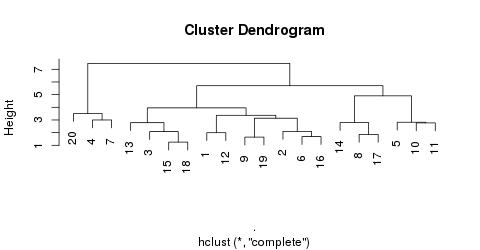

In [136]:
%%R -h 250
df.l2fc.j.s.w = df.l2fc.j.s %>% 
    select(SubDay_LM, func_group, mean_l2fc) %>%
    spread(func_group, mean_l2fc) %>%
    as.data.frame

df.l2fc.j.s.w$SubDay_LM = NULL

df.l2fc.j.s.w.d = df.l2fc.j.s.w %>% t %>% dist
df.l2fc.j.s.hc = df.l2fc.j.s.w.d %>% hclust
df.l2fc.j.s.hc %>% plot

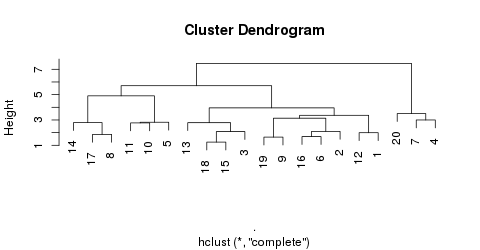

In [137]:
%%R -h 250
ro = c(26:1)
df.l2fc.j.s.hc.r = reorder(df.l2fc.j.s.hc, ro) 
df.l2fc.j.s.hc.r %>% plot

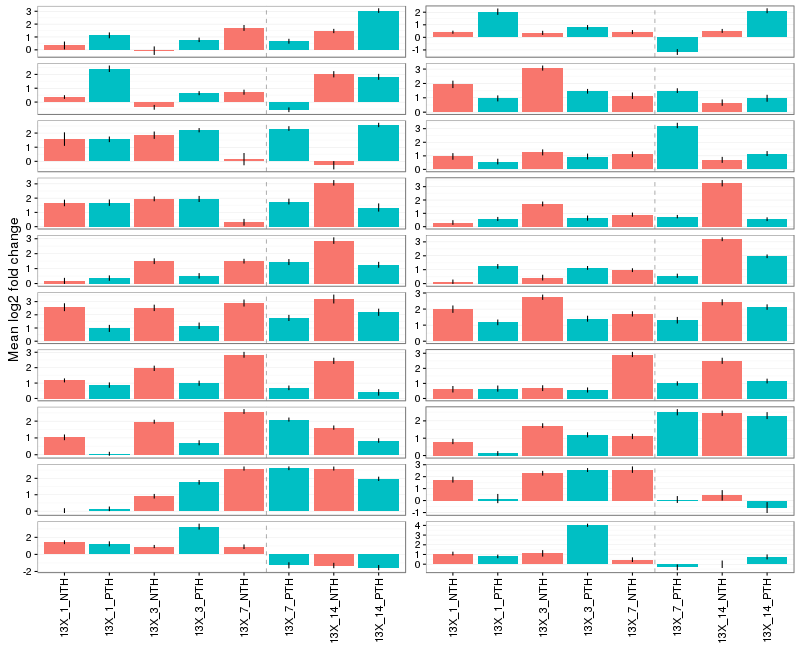

In [138]:
%%R -w 800 -h 650

# dendrogram order; split into 2 groups
FG_labs = df.l2fc.j.s.hc.r$labels[df.l2fc.j.s.hc.r$order] %>% as.numeric

# reorder
df.l2fc.j.s.e = df.l2fc.j.s %>%
    filter(func_group %in% FG_labs) %>%
    mutate(func_group = factor(func_group, levels=FG_labs))

# plot
p.l2fc2= ggplot(df.l2fc.j.s.e, aes(SubDay_LM, mean_l2fc, fill=Land_Management,
                        ymin=mean_l2fc-stderr_l2fc,
                        ymax=mean_l2fc+stderr_l2fc)) +
    geom_bar(stat='identity') +
    geom_linerange() +
   # scale_x_discrete(labels=x.labs) +
    geom_vline(xintercept=c(5.5, 12.5, 21.5, 29.5, 32.5), linetype='dashed', alpha=0.3) +
    labs(y='Mean log2 fold change') +
    facet_wrap(~ func_group, scales='free_y', ncol=2) +
    theme_bw() +
    theme(
        text = element_text(size=14),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5),
        axis.text.y = element_text(size=10),
        panel.grid.major.x = element_blank(),
        strip.background = element_blank(),
        strip.text = element_blank(),
        legend.position='none'
    )
p.l2fc2

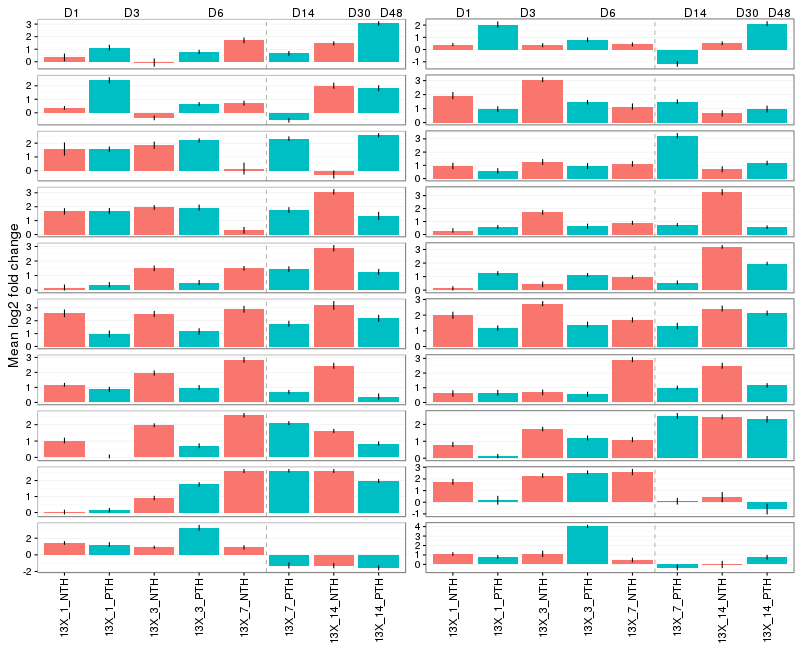

In [139]:
%%R -w 800 -h 650

d.labs = rep(c('D1', 'D3', 'D6', 'D14', 'D30', 'D48'), 2)
d.labs.x = c(0.070, 0.145, 0.250, 0.350, 0.420, 0.460,
             0.560, 0.640, 0.740, 0.840, 0.905, 0.945)
d.labs.y = rep(0.995, length(d.labs))

cowplot::ggdraw() +
    cowplot::draw_plot(p.l2fc2, 0, 0, 1, 0.98) +
    cowplot::draw_plot_label(d.labs, d.labs.x, d.labs.y, size=12, fontface='plain')

# Decision tree

* Creating more general descriptive variables for characteristics of each functional group
* Using manually defined decision tree

* Tree (based on majority rules for OTUs in each functional guild):
  * OC_generalist (incorporator for both DOC & POC & vanillin)
    * primary_consumer (incorporatation in 1st or second time point)
    * secondary_consumer (incorporatation only in >= 3rd time point)
  * OC_specialist (incorporator for 2 of: DOC, POC, & vanillin)
    * vanillin_specialist
      * primary_consumer
      * seconary_consumer
    * DOC_specialist
      * primary_consumer
      * secondary_consumer
    * POC_specialist
      * primary_consumer
      * secondary_consumer

In [140]:
%%R -w 800
df.l2fc.j.s = df.l2fc.j %>%
    unite(SubDay, Substrate, Day, sep='_', remove=FALSE) %>%
    group_by(func_group, SubDay, Substrate, Day) %>%
    summarize(mean_l2fc = mean(log2FoldChange),
              stderr_l2fc = sd(log2FoldChange) / sqrt(length(log2FoldChange)),
              Incorp_perc = sum(Incorporator) / n()) %>%
    ungroup() %>%
    group_by(func_group) %>%
    mutate(mean_l2fc_norm = mean_l2fc / max(mean_l2fc)) %>%
    ungroup() %>%
    mutate(FG_incorp = (mean_l2fc_norm > 0.25))

ggplot(df.l2fc.j.s, aes(Day, mean_l2fc_norm, color=FG_incorp, group=func_group)) +
    geom_point() +
    geom_line() +
    facet_wrap(~ Substrate, scales='free_x') +
    theme_bw()


Error in eval(expr, envir, enclos) : object 'Substrate' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 4: Stacking not well defined when ymin != 0 

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [141]:
%%R -w 600 -h 250

df_OC = data.frame(
    'Substrate' = c('13C-Ami','13C-Cel','13C-Glu','13C-Gly','13C-Lac','13C-Oxa','13C-Pal','13C-Van','13C-Xyl'),
    'OC' = c('DOC','POC','DOC','DOC','DOC','DOC','POC','Van','DOC')
)


FG_OC_classify_OLD = function(df){
    # OC specialist/generalist
    OCs = df$OC %>% unique
    n_OCs = OCs %>% length
    if(n_OCs == 3){
        return('OC generalist')
    } else
    if(n_OCs == 2){
        return('OC specialist')
    } else{
        print(OCs[1])
        if(OCs[1] == 'DOC'){
            return('DOC specialist')
        } else
        if(OCs[1] == 'POC'){
            return('POC specialist')
        } else
        if(OCs[1] == 'VAN'){
            return('Van specialist')
        }
    }
    return('Unclassified')
}
 
FG_OC_classify = function(df){
    # OC specialist/generalist
    OCs = df$OC %>% unique
    n_OCs = OCs %>% length
    if(n_OCs == 3){
        return('OC-Van generalist')
    } else
    if(n_OCs == 2){
        if(all(OCs %in% c('DOC', 'POC'))){
            return('OC specialist')
        } else
        if(all(OCs %in% c('DOC', 'Van'))){
            return('DOC-Van specialist')
        } else
        if(all(OCs %in% c('POC', 'Van'))){
            return('POC-Van specialist')
        } else {
            print('L2 error')
        }
    }
    if(n_OCs == 1){
        if(OCs[1] == 'DOC'){
            return('DOC specialist')
        } else
        if(OCs[1] == 'POC'){
            return('POC specialist')
        } else
        if(OCs[1] == 'Van'){
            return('Van specialist')
        } else {
            print('L3 error')
        }
    }
    return('Unclassified')
}        
        
FG_con_classify = function(df){
    # direct/indirect consumer
    df = df %>% 
        group_by(Substrate) %>%
        mutate(Day_rank = row_number(Day),
               n_days = Day %>% unique %>% length,
               Day_rank = Day_rank / n_days)
        
    if(any(df$Day_rank < 0.5)){
        return('Direct consumer')
    } else {
        return('Indirect consumer')
    }
    return('Unclassified')
}
    
        

df.l2fc.j.s.c = inner_join(df.l2fc.j.s, df_OC, c('Substrate'='Substrate')) %>% 
    group_by(func_group) %>%
    filter(FG_incorp == TRUE) %>%
    nest() %>%
    mutate(OC_cls = lapply(data, FG_OC_classify),
           con_cls = lapply(data, FG_con_classify)) %>%   
    unnest(OC_cls = purrr::map(OC_cls, function(x) x),
           con_cls = purrr::map(con_cls, function(x) x))
    

# summarizing 
df.l2fc.j.s.c.s = df.l2fc.j.s.c %>%
    group_by(OC_cls, con_cls) %>%
    summarize(n=n()) %>%
    ungroup() %>%
    complete(OC_cls, con_cls)

L = c('OC-Van generalist',
      'OC specialist',
      'DOC-Van specialist',
      'POC-Van specialist',
      'DOC specialist',
      'POC specialist',
      'Van specialist')
df.l2fc.j.s.c.s$OC_cls = factor(df.l2fc.j.s.c.s$OC_cls, levels=L)
               
ggplot(df.l2fc.j.s.c.s, aes(OC_cls, n, fill=con_cls)) +
    geom_bar(stat='identity', position='dodge') +
    labs(y='Number of\nfunctional guilds') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=45, hjust=1)
    )


Error in eval(expr, envir, enclos) : 
  cannot join on columns 'Substrate' x 'Substrate': index out of bounds


### Reordering l2fc plots by classifications

In [142]:
%%R -w 800 -h 650
as.Num = function(x) x %>% as.character %>% as.numeric

df.l2fc.j.s.j = inner_join(df.l2fc.j.s %>% mutate(func_group = func_group %>% as.Num), 
                             df.l2fc.j.s.c %>% dplyr::select(func_group, OC_cls, con_cls), 
                             c('func_group'='func_group')) %>%
        mutate(con_cls = ifelse(con_cls=='Direct consumer', 'DC', 'IC')) %>%
        unite(cls, OC_cls, con_cls, sep=': ', remove=FALSE) %>%
        mutate(SubDay = SubDay %>% reorder(gsub('.+_0*', '', SubDay) %>% as.numeric))

# reorder functional group
L = df.l2fc.j.s.j %>%
    dplyr::select(func_group, cls) %>%
    distinct(func_group, cls) %>%
    arrange(cls)
L = L$func_group %>% as.numeric    
    
df.l2fc.j.s.j$func_group = factor(df.l2fc.j.s.j$func_group, levels=L)

    
# plot
p.l2fc2 = ggplot(df.l2fc.j.s.j, aes(SubDay, mean_l2fc, fill=cls,
                        ymin=mean_l2fc-stderr_l2fc,
                        ymax=mean_l2fc+stderr_l2fc)) +
    geom_bar(stat='identity') +
    geom_linerange() +
    scale_x_discrete(labels=x.labs) +
    geom_vline(xintercept=c(5.5, 12.5, 21.5, 29.5, 32.5), linetype='dashed', alpha=0.3) +
    labs(y='Mean log2 fold change') +
    facet_wrap(~ func_group, scales='free_y', ncol=2) +
    theme_bw() +
    theme(
        text = element_text(size=14),
        axis.title.x = element_blank(),
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5),
        axis.text.y = element_text(size=10),
        panel.grid.major.x = element_blank(),
        strip.background = element_blank(),
        strip.text = element_blank()#,
#        legend.position='none'
    )
p.l2fc2


Error in eval(expr, envir, enclos) : object 'df.l2fc.j.s.c' not found


***
***
# --OLD--

## rpart

### l2fc

In [143]:
%%R
library(rpart)
library(randomForest)

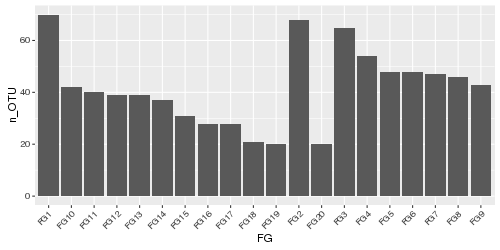

In [144]:
%%R -w 500 -h 250
df.l2fc.w.j = inner_join(df.l2fc.w %>% mutate(OTU=rownames(.)), df_splits, c('OTU' = 'OTU')) %>%
    rename('FG' = splits) %>% 
    mutate(FG=FG%>%as.character,
           FG = gsub('^', 'FG', FG))


df.l2fc.w.j.s = df.l2fc.w.j %>%
    group_by(FG) %>%
    summarize(n_OTU = OTU %>% unique %>% length) %>%
    ungroup() 

ggplot(df.l2fc.w.j.s, aes(FG, n_OTU)) +
    geom_bar(stat='identity') +
    theme(
        axis.text.x = element_text(angle=45, hjust=1)
    )

In [145]:
%%R -w 800 -h 650

F = FG ~ Ami_D01+Ami_D14+Ami_D03+Ami_D06+Cel_D14+Cel_D03+Cel_D30+
Cel_D48+Cel_D06+Glu_D01+Glu_D14+Glu_D03+Glu_D06+Gly_D01+
Gly_D14+Gly_D03+Gly_D06+Lac_D01+Lac_D03+Lac_D06+Oxa_D14+
Oxa_D03+Oxa_D06+Pal_D14+Pal_D30+Pal_D48+Pal_D06+Van_D14+
Van_D30+Van_D48+Van_D06+Xyl_D01+Xyl_D14+Xyl_D03+Xyl_D06

rtree = rpart(F, data=df.l2fc.w.j , method='class')
#rtree = rpart::prune(rtree, cp=0.1)
rtree = maptree::clip.rpart(rtree, best=10)
maptree::draw.tree(rtree, nodeinfo=TRUE, units='FG', cases='OTUs', digits=1)


Error in eval(expr, envir, enclos) : object 'Ami_D01' not found


In [146]:
%%R
rsq.rpart(rtree)


Error in rsq.rpart(rtree) : object 'rtree' not found


In [147]:
%%R
predict(rtree, type='class') %>% summary


Error in predict(rtree, type = "class") : object 'rtree' not found


In [148]:
%%R
RF.res = randomForest(F, data=df.l2fc.w.j, importance=TRUE, proximity=TRUE)
#RF.res.I = round(importance(RF.res), 3)
RF.res.I %>% head


Error in eval(expr, envir, enclos) : object 'Ami_D01' not found


In [149]:
%%R
sort(RF.res.I[,'MeanDecreaseAccuracy'], decreasing=TRUE)


Error in sort(RF.res.I[, "MeanDecreaseAccuracy"], decreasing = TRUE) : 
  object 'RF.res.I' not found


In [150]:
%%R
RF.res$model


Error in withVisible({ : object 'RF.res' not found


### Just incorporator status

In [151]:
%%R 
# selecting all incorporator OTUs, keeping l2fc values for all substrates/days

cat('Total number of incorporator OTUs:', df.inc$OTU %>% unique %>% length, '\n')

df.l2fc.I.w = df.l2fc %>%
    filter(OTU %in% df.inc$OTU) %>%
    mutate(Day = gsub('^', 'D', Day),
           Incorporator = Incorporator %>% as.character) %>%
    unite(Substrate_Day, Substrate, Day, sep='_') %>%
    dplyr::select(OTU, Substrate_Day, Incorporator) %>%
    spread(Substrate_Day, Incorporator, fill='0') 

rownames(df.l2fc.I.w) = df.l2fc.I.w$OTU
df.l2fc.I.w$OTU = NULL
colnames(df.l2fc.I.w) = gsub('13C-', '', colnames(df.l2fc.I.w))
colnames(df.l2fc.I.w) = gsub('D([0-9])$', 'D0\\1', colnames(df.l2fc.I.w))

df.l2fc.I.w %>% nrow %>% print
df.l2fc.I.w %>% head(n=3)

Total number of incorporator OTUs: 834
Error in eval(expr, envir, enclos) : object 'Substrate' not found


In [152]:
%%R
df.l2fc.I.w.j = inner_join(df.l2fc.I.w %>% mutate(OTU=rownames(.)), df_splits, c('OTU' = 'OTU')) %>%
    rename('FG' = splits) 

df.l2fc.I.w.j %>% head(n=3)


Error in eval(expr, envir, enclos) : object 'df.l2fc.I.w' not found


In [153]:
%%R -w 800 -h 650

F = as.factor(FG) ~ Ami_D01+Ami_D14+Ami_D03+Ami_D06+Cel_D14+Cel_D03+Cel_D30+
Cel_D48+Cel_D06+Glu_D01+Glu_D14+Glu_D03+Glu_D06+Gly_D01+
Gly_D14+Gly_D03+Gly_D06+Lac_D01+Lac_D03+Lac_D06+Oxa_D14+
Oxa_D03+Oxa_D06+Pal_D14+Pal_D30+Pal_D48+Pal_D06+Van_D14+
Van_D30+Van_D48+Van_D06+Xyl_D01+Xyl_D14+Xyl_D03+Xyl_D06

rtree = rpart(F, data=df.l2fc.I.w.j)
#rtree = rpart::prune(rtree, cp=0.1)
rtree = maptree::clip.rpart(rtree, best=10)
maptree::draw.tree(rtree, nodeinfo=TRUE, units='FG', cases='OTUs', digits=1)


Error in is.data.frame(data) : object 'df.l2fc.I.w.j' not found


In [154]:
%%R
RF.res = randomForest(F, data=df.l2fc.I.w.j, importance=TRUE, proximity=TRUE)
RF.res.I = round(importance(RF.res), 3)
RF.res.I %>% head(n=3)


Error in eval(expr, envir, enclos) : object 'df.l2fc.I.w.j' not found


In [155]:
%%R
sort(RF.res.I[,'MeanDecreaseAccuracy'], decreasing=TRUE)


Error in sort(RF.res.I[, "MeanDecreaseAccuracy"], decreasing = TRUE) : 
  object 'RF.res.I' not found


In [156]:
%%R
varImpPlot(RFu.res)


Error in inherits(x, "randomForest") : object 'RFu.res' not found


### Incorporator status: any day

In [157]:
%%R 
# selecting all incorporator OTUs, keeping l2fc values for all substrates/days

cat('Total number of incorporator OTUs:', df.inc$OTU %>% unique %>% length, '\n')

df.l2fc.I.w = df.l2fc %>%
    filter(OTU %in% df.inc$OTU) %>%
    group_by(OTU, Substrate) %>%
    summarize(Incorporator = any(Incorporator)) %>%
    ungroup() %>%
    mutate(Incorporator = ifelse(Incorporator==TRUE, '1', '0')) %>%
    dplyr::select(OTU, Substrate, Incorporator) %>%
    spread(Substrate, Incorporator, fill='0') %>%
    as.data.frame

rownames(df.l2fc.I.w) = df.l2fc.I.w$OTU %>% as.character
df.l2fc.I.w$OTU = NULL
colnames(df.l2fc.I.w) = gsub('13C-', '', colnames(df.l2fc.I.w))
#colnames(df.l2fc.I.w) = gsub('D([0-9])$', 'D0\\1', colnames(df.l2fc.I.w))

df.l2fc.I.w %>% nrow %>% print
df.l2fc.I.w %>% head(n=3)

Total number of incorporator OTUs: 834
Error in eval(expr, envir, enclos) : unknown column 'Substrate'


In [158]:
%%R
df.l2fc.I.w.j = inner_join(df.l2fc.I.w %>% mutate(OTU=rownames(.)), df_splits, c('OTU' = 'OTU')) %>%
    rename('FG' = splits) 

df.l2fc.I.w.j %>% head(n=3)


Error in eval(expr, envir, enclos) : object 'df.l2fc.I.w' not found


In [159]:
%%R -w 800 -h 650

F = as.factor(FG) ~ Ami+Cel+Glu+Gly+Lac+Oxa+Pal+Van+Xyl

rtree = rpart(F, data=df.l2fc.I.w.j)
#rtree = rpart::prune(rtree, cp=0.1)
rtree = maptree::clip.rpart(rtree, best=26)
maptree::draw.tree(rtree, nodeinfo=TRUE, units='FG', cases='OTUs', digits=1)


Error in is.data.frame(data) : object 'df.l2fc.I.w.j' not found


In [160]:
%%R
RF.res = randomForest(F, data=df.l2fc.I.w.j, importance=TRUE)
RF.res.I = round(importance(RF.res), 3)
RF.res.I %>% head


Error in eval(expr, envir, enclos) : object 'df.l2fc.I.w.j' not found


In [161]:
%%R
sort(RF.res.I[,'MeanDecreaseAccuracy'], decreasing=TRUE)


Error in sort(RF.res.I[, "MeanDecreaseAccuracy"], decreasing = TRUE) : 
  object 'RF.res.I' not found


## REEMtree

In [162]:
%%R
library(REEMtree)

In [163]:
%%R
df.l2fc.w.j.l = df.l2fc.w.j %>% 
    gather(Sample, l2fc, 1:(ncol(.) - 2)) %>%
    separate(Sample, c('Substrate', 'Day'), sep='_') %>%
    mutate(Day = gsub('D0*', '', Day) %>% as.numeric,
           FG = FG %>% as.character)
df.l2fc.w.j.l %>% head   

        OTU   FG Substrate Day       l2fc
1     OTU.1  FG6       13X  NA  1.5463473
2    OTU.10 FG13       13X  NA  2.2023602
3   OTU.100 FG17       13X  NA  0.2481337
4 OTU.10048  FG4       13X  NA  2.2109761
5  OTU.1005 FG15       13X  NA -0.8601863
6 OTU.10051 FG11       13X  NA  1.1346564


In [164]:
%%R
REEM.res = REEMtree(l2fc ~ FG + Substrate + Day, data=df.l2fc.w.j.l, random=~1|OTU)
REEM.res

[1] "*** RE-EM Tree ***"
n= 6672 

node), split, n, deviance, yval
      * denotes terminal node

1) root 6672 11519.480 1.1550150  
  2) FG=FG10,FG11,FG14,FG15,FG17,FG18,FG20,FG3,FG4,FG5,FG6,FG7,FG8 4216  7695.795 0.9181575 *
  3) FG=FG1,FG12,FG13,FG16,FG19,FG2,FG9 2456  3181.138 1.5616080 *
[1] "Estimated covariance matrix of random effects:"
            (Intercept)
(Intercept)   0.3939662
[1] "Estimated variance of errors: 1.77222282994769"
[1] "Log likelihood:  -11805.8996460421"


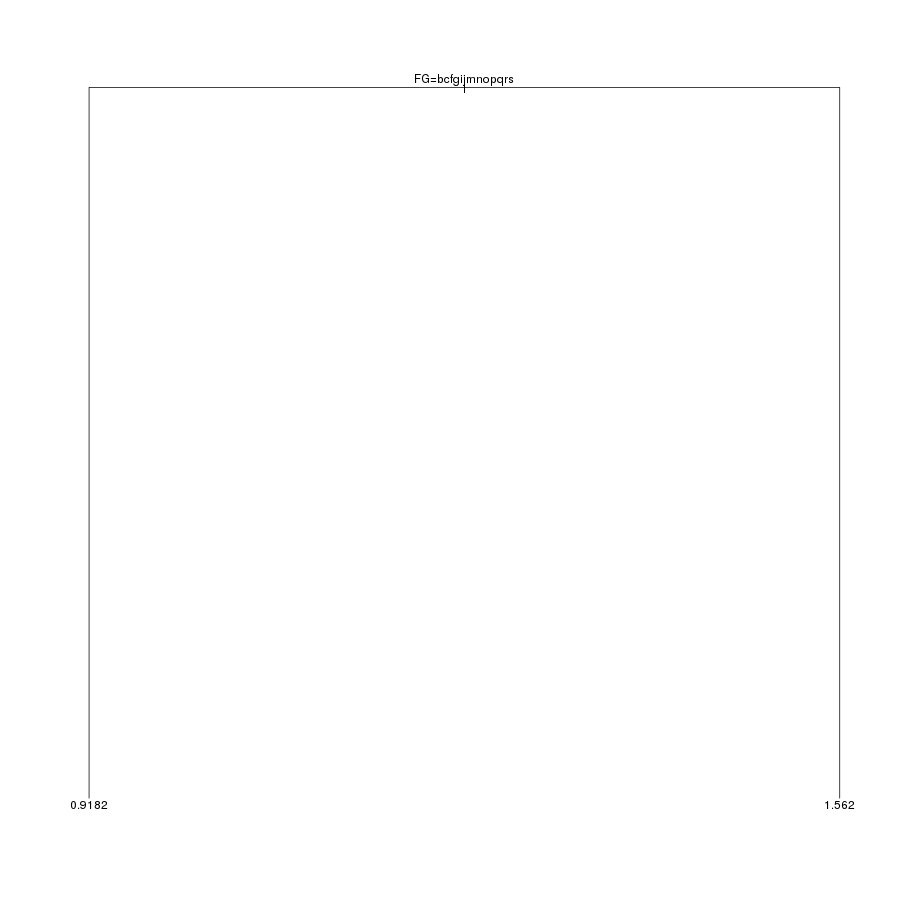

In [165]:
%%R -w 900 -h 900
plot(REEM.res, text=FALSE, show.tip.label=FALSE)

In [166]:
%%R
df.l2fc.w.j.l = df.l2fc.w.j %>% 
    gather(Sample, l2fc, 1:(ncol(.) - 2)) %>%
    separate(Sample, c('Substrate', 'Day'), sep='_') %>%
    mutate(Day = gsub('D0*', '', Day) %>% as.numeric,
           FG = FG %>% as.character) %>%
    group_by(OTU, Substrate, FG) %>%
    summarize(l2fc = mean(l2fc)) %>%
    ungroup %>%
    as.data.frame
df.l2fc.w.j.l %>% head   

        OTU Substrate   FG      l2fc
1     OTU.1       13X  FG6 1.6948186
2    OTU.10       13X FG13 3.1180244
3   OTU.100       13X FG17 0.4676100
4 OTU.10048       13X  FG4 0.6565215
5  OTU.1005       13X FG15 1.1784488
6 OTU.10051       13X FG11 0.1422248


In [167]:
%%R
REEM.res = REEMtree(l2fc ~ FG + Substrate, data=df.l2fc.w.j.l, random=~1|OTU)
REEM.res 

[1] "*** RE-EM Tree ***"
n= 834 

node), split, n, deviance, yval
      * denotes terminal node

1) root 834 111.4779000 1.1550150  
  2) FG=FG10,FG11,FG14,FG15,FG17,FG18,FG20,FG3,FG4,FG5,FG6,FG7,FG8 527  27.8118100 0.9181575  
    4) FG=FG17,FG4,FG7 129   0.8536833 0.5453763 *
    5) FG=FG10,FG11,FG14,FG15,FG18,FG20,FG3,FG5,FG6,FG8 398   3.2211630 1.0389840 *
  3) FG=FG1,FG12,FG13,FG16,FG19,FG2,FG9 307   3.3480670 1.5616080 *
[1] "Estimated covariance matrix of random effects:"
            (Intercept)
(Intercept)   0.5152182
[1] "Estimated variance of errors: 0.0724525550802851"
[1] "Log likelihood:  -966.549463641926"


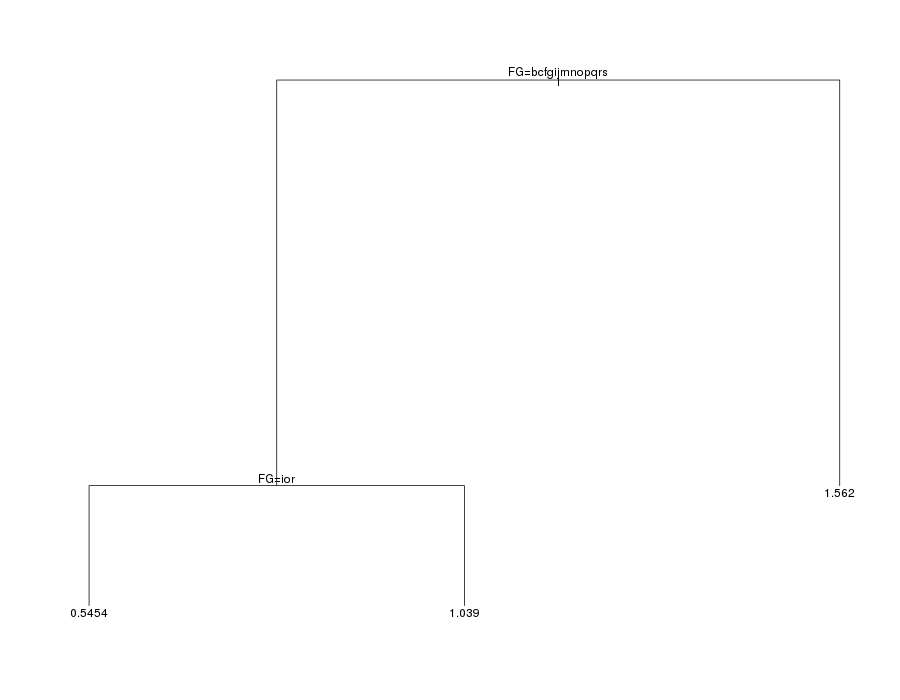

In [168]:
%%R -w 900 -h 700
plot(REEM.res, text=FALSE, show.tip.label=FALSE)

# --OLD--

In [169]:
%%R
# labeling functional guilds (heatmap splits)
split_labels = list(
'1' = 'Generalists: days 14-48',
'2' = 'Generatlists: days 3-6',
'3' = 'Specialists: cellulose, days 14-30 & palmitic acid, day 30',
'4' = 'Specialists: palmitic acid, day 30',
'5' = 'Specialists: glucose',
'6' = 'Specialists: vanillin, day 48',
'7' = 'Specialists: lactate, day 6 & oxalate day 14',
'8' = 'Specialists: cellulose, days 14-30 & palmitic acid, days 14-30',
'9' = 'Specialists: palmitic acid, day 48',
'10' = 'Generalists: labile substrate bias',
'11' = 'Generalists: days 14-30',
'12' = 'Specialists: cellulose, day 30 & palmitic acid, day 30',
'13' = 'Specialists: labile substrates and vanillin',
'14' = 'Specialists: cellulose, days 14-48 & palmitic acid, days 14-48',
'15' = 'Specialists: vannilin day 14-48',
'16' = 'Specialists: cellulose, day 14',
'17' = 'Specialists: vannilin, day 30 & cellulose, day 30',
'18' = 'Generalists: day 14',
'19' = 'Generalists: labile substrates, day 14 & recalcitrant, day 30',
'20' = 'Specialists: vannilin, day 6 & palmitic acid day 6',
'21' = 'Specialists: cellulose, day 48',
'22' = 'Specialists: palmitic acid, day 14',
'23' = 'Specialists: lactate, days 1-3',
'24' = 'Specialists: labile substrates, day 3',
'25' = 'Specialists: labile substrates, day 14',
'26' = 'Specialists: vanillin, day 48 & cellulose, day 48'
)